In [44]:
# Configuration settings
CONFIG = {
    'ticker': 'AAPL',
    'data_path': '../data/',
    'charts_path': '../charts/',
    'random_seed': 42,
    'synthetic_samples': 20
}

# Create directories if they don't exist
import os
os.makedirs(CONFIG['data_path'], exist_ok=True)
os.makedirs(CONFIG['charts_path'], exist_ok=True)

# Market Analysis through Sentiment Analysis

This notebook walks through the process of building a sentiment analysis system to predict stock movements by scraping financial news and social media data, performing sentiment analysis, and then using that sentiment to build a simple model to predict stock price changes.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup

# Set plot style
sns.set(style='whitegrid')

## 1. Scrape Financial News Headlines

This section focuses on collecting financial news headlines from Finviz. The process involves:

1. Making an HTTP request to the Finviz quote page
2. Parsing the HTML to extract news headlines
3. Processing the dates and times
4. Handling various edge cases and errors

Note: Web scraping may be subject to rate limiting or terms of service restrictions.

In [ ]:
from datetime import date, datetime, timedelta
import logging
from typing import List, Tuple, Optional
import time

def get_finviz_news(ticker: str, min_articles: int = 100) -> pd.DataFrame:
    try:
        url = f'https://finviz.com/quote.ashx?t={ticker}'
        headers = {
            'User-Agent': 'Mozilla/5.0',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9',
            'Accept-Language': 'en-US,en;q=0.5'
        }
        
        # Initialize storage for all news
        all_news_list: List[Tuple[date, Optional[str], str]] = []
        
        # Make request with timeout and error handling
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = requests.get(url, headers=headers, timeout=10)
                response.raise_for_status()
                
                soup = BeautifulSoup(response.text, 'html.parser')
                news_table = soup.find(id='news-table')
                
                if news_table is None:
                    logging.warning(f"No news table found for ticker {ticker}")
                    continue
                
                current_date = None
                
                for row in news_table.find_all('tr'):
                    try:
                        title_element = row.find('a')
                        datetime_element = row.find('td')

                        if not (title_element and datetime_element):
                            continue

                        title = title_element.get_text().strip()
                        datetime_str = datetime_element.get_text().strip()
                        
                        if "Today" in datetime_str:
                            today_str = date.today().strftime('%b-%d-%y')
                            datetime_str = datetime_str.replace("Today", today_str)

                        if ' ' in datetime_str:
                            dt = pd.to_datetime(datetime_str, format='%b-%d-%y %I:%M%p')
                            current_date = dt.date()
                            time = dt.time()
                        else:
                            time = pd.to_datetime(datetime_str, format='%I:%M%p').time()

                        if current_date and title:
                            all_news_list.append([current_date, time, title])
                            
                    except (ValueError, AttributeError) as e:
                        logging.debug(f"Error processing news row: {e}")
                        continue
                
                # If we have enough articles, break
                if len(all_news_list) >= min_articles:
                    break
                    
                # Wait before retry to be polite
                time.sleep(2)
                
            except requests.RequestException as e:
                logging.error(f"Attempt {attempt + 1} failed: {str(e)}")
                if attempt == max_retries - 1:
                    raise
                time.sleep(2)  # Wait before retry

        df = pd.DataFrame(all_news_list, columns=['date', 'time', 'headline'])
        
        # Print data quality information
        print("\nNews Data Quality Check:")
        print("1. Date range:", df['date'].min(), "to", df['date'].max())
        print("2. Number of articles:", len(df))
        print("3. Articles per day:", len(df) / (len(df['date'].unique()) or 1))
        print("4. Unique dates:", len(df['date'].unique()))
        
        # Save the scraped data
        output_path = os.path.join(CONFIG['data_path'], f'{ticker}_finviz_news.csv')
        df.to_csv(output_path, index=False)
        print(f"\nSaved news data to {output_path}")
        
        return df
        
    except requests.RequestException as e:
        logging.error(f"Error fetching news for {ticker}: {e}")
        return pd.DataFrame([], columns=['date', 'time', 'headline'])
    except Exception as e:
        logging.error(f"Unexpected error processing news for {ticker}: {e}")
        return pd.DataFrame([], columns=['date', 'time', 'headline'])

# Set up logging
logging.basicConfig(level=logging.INFO)

# Scrape news for the configured ticker
print(f"Fetching news data for {CONFIG['ticker']}...")
news_df = get_finviz_news(CONFIG['ticker'], min_articles=100)  # Try to get at least 100 articles
print(f"\nRetrieved {len(news_df)} news items")
display(news_df.head())

Fetching news data for AAPL...

News Data Quality Check:
1. Date range: 2025-10-14 to 2025-10-17
2. Number of articles: 100
3. Articles per day: 25.0
4. Unique dates: 4

Saved news data to ../data/AAPL_finviz_news.csv

Retrieved 100 news items

News Data Quality Check:
1. Date range: 2025-10-14 to 2025-10-17
2. Number of articles: 100
3. Articles per day: 25.0
4. Unique dates: 4

Saved news data to ../data/AAPL_finviz_news.csv

Retrieved 100 news items


,date,time,headline
0,2025-10-17,03:50:00,Better Stock to Buy Right Now: Apple vs. Amazon
1,2025-10-16,23:57:00,"Apple plans touch-screen MacBook Pro for 2026,..."
2,2025-10-16,18:25:00,Apple revs up for F1 rights: Here's what to know
3,2025-10-16,17:30:00,Apple reportedly loses another exec. to Meta: ...
4,2025-10-16,16:04:00,"Stock market today: Dow drops 300 points, S&P ..."


## 2. Perform Sentiment Analysis

In [47]:
analyzer = SentimentIntensityAnalyzer()
news_df['compound'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df.head()

,date,time,headline,compound
0,2025-10-17,03:50:00,Better Stock to Buy Right Now: Apple vs. Amazon,0.5574
1,2025-10-16,23:57:00,"Apple plans touch-screen MacBook Pro for 2026,...",0.0000
2,2025-10-16,18:25:00,Apple revs up for F1 rights: Here's what to know,0.0000
3,2025-10-16,17:30:00,Apple reportedly loses another exec. to Meta: ...,-0.3182
4,2025-10-16,16:04:00,"Stock market today: Dow drops 300 points, S&P ...",-0.4404


## 3. Fetch Historical Stock Price Data

In [ ]:
if not news_df.empty:
    # Print date range from news data
    print(f"News data date range: {news_df['date'].min()} to {news_df['date'].max()}")
    
    # Fetch stock data
    start_date = pd.to_datetime(news_df['date'].min()) - pd.Timedelta(days=90)  # Get 90 days of history
    end_date = pd.to_datetime(news_df['date'].max()) + pd.Timedelta(days=5)    # Get 5 extra days after
    
    print(f"\nFetching stock data from {start_date.date()} to {end_date.date()}")
    
    # Try multiple attempts with error handling
    max_retries = 3
    for attempt in range(max_retries):
        try:
            stock_data = yf.download(
                CONFIG['ticker'], 
                start=start_date, 
                end=end_date,
                progress=False,
                interval="1d"  # Daily data
            )
            if not stock_data.empty:
                break
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                raise
            time.sleep(2)  # Wait before retry
    
    # Force standard column names
    stock_data = stock_data.reset_index()
    print(f"\nRetrieved {len(stock_data)} days of stock data")
    
    if len(stock_data) < 60:  # Minimum requirement for stock data
        print("Warning: Retrieved less than 60 days of stock data. Model results may be unreliable.")
    
    # Print the column structure
    print("Original columns:", stock_data.columns)
    
    # Force rename columns to standard names
    new_column_names = ['date', 'open', 'high', 'low', 'close', 'volume']
    
    if len(stock_data.columns) == len(new_column_names):
        stock_data.columns = new_column_names
    else:
        if isinstance(stock_data.columns, pd.MultiIndex):
            new_cols = ['date']
            for i in range(1, len(stock_data.columns)):
                if i-1 < len(new_column_names)-1:
                    new_cols.append(new_column_names[i])
                else:
                    new_cols.append(f"column_{i}")
            stock_data.columns = new_cols
        else:
            if len(stock_data.columns) >= 5:
                temp_cols = list(stock_data.columns)
                stock_data = stock_data.rename(columns={
                    temp_cols[0]: 'date',
                    temp_cols[1]: 'open',
                    temp_cols[2]: 'high', 
                    temp_cols[3]: 'low',
                    temp_cols[4]: 'close'
                })
                if len(temp_cols) > 5:
                    stock_data = stock_data.rename(columns={temp_cols[5]: 'volume'})
    
    # Ensure the date column is in the correct format
    stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date
    
    # Data quality checks
    print("\nStock Data Quality Check:")
    print("1. Date range:", stock_data['date'].min(), "to", stock_data['date'].max())
    print("2. Number of trading days:", len(stock_data))
    print("3. Missing values:")
    print(stock_data.isnull().sum())
    print("\n4. Basic statistics:")
    print(stock_data.describe())
    
    # Check for gaps in trading days
    all_days = pd.date_range(stock_data['date'].min(), stock_data['date'].max(), freq='B')
    missing_days = set(all_days.date) - set(stock_data['date'])
    if missing_days:
        print(f"\nWarning: Found {len(missing_days)} missing trading days")
        print("First few missing days:", sorted(list(missing_days))[:5])
    
    # Save the cleaned stock data
    output_path = os.path.join(CONFIG['data_path'], f'{CONFIG["ticker"]}_stock_data_clean.csv')
    stock_data.to_csv(output_path, index=False)
    print(f"\nSaved clean stock data to {output_path}")
else:
    print("News data is empty. Cannot fetch stock data.")
    stock_data = pd.DataFrame()

News data date range: 2025-10-14 to 2025-10-17

Fetching stock data from 2025-07-16 to 2025-10-22

Retrieved 66 days of stock data
Original columns: MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

Stock Data Quality Check:
1. Date range: 2025-07-16 to 2025-10-16
2. Number of trading days: 66
3. Missing values:
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

4. Basic statistics:
             open        high         low       close        volume
count   66.000000   66.000000   66.000000   66.000000  6.600000e+01
mean   233.042533  235.186147  230.862404  233.011926  5.417942e+07
std     16.617051   16.378906   16.370615   16.459389  2.330461e+07
min    202.150589  205.107211  201.271582  203.169408  3.062120e+07
25%    221.060421  222.079732  217.001222  219.118821  4.

C:\Users\nikhi\AppData\Local\Temp\ipykernel_13308\160447582.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(


## 4. Combine Sentiment and Stock Data

In [49]:
if not news_df.empty and not stock_data.empty:
    # Print initial data info
    print("Initial Data Summary:")
    print(f"News data shape: {news_df.shape}")
    print(f"Stock data shape: {stock_data.shape}")
    
    # Aggregate sentiment scores by date with more statistics
    sentiment_by_date = news_df.groupby('date').agg({
        'compound': ['mean', 'count', 'std']
    }).reset_index()
    
    # Flatten column names
    sentiment_by_date.columns = ['date', 'sentiment_score', 'news_count', 'sentiment_std']
    
    print("\nSentiment Statistics:")
    print(f"Date range: {sentiment_by_date['date'].min()} to {sentiment_by_date['date'].max()}")
    print(f"Days with news: {len(sentiment_by_date)}")
    print("\nNews count per day:")
    print(sentiment_by_date['news_count'].describe())

    # Merge with stock data on the date column
    print("\nMerging data...")
    merged_df = pd.merge(stock_data, sentiment_by_date, on='date', how='left')
    
    # Print merge results
    print(f"\nMerged data shape: {merged_df.shape}")
    print("Missing values per column:")
    print(merged_df.isnull().sum())
    
    # Fill missing sentiment scores with 0 (neutral)
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)
    merged_df['sentiment_std'] = merged_df['sentiment_std'].fillna(0)
    merged_df['news_count'] = merged_df['news_count'].fillna(0)
    
    # Force all columns to lowercase
    merged_df.columns = [x.lower() for x in merged_df.columns]
    
    # Set date as index
    merged_df = merged_df.set_index('date')
    
    print("\nFinal merged data summary:")
    print(merged_df.describe())
    print("\nFirst few rows:")
    display(merged_df.head())
    
    # Save the merged data
    output_path = os.path.join(CONFIG['data_path'], f'{CONFIG["ticker"]}_sentiment_analysis.csv')
    merged_df.to_csv(output_path)
    print(f"\nSaved merged data to {output_path}")
else:
    print("Stock or news data is empty. Cannot merge.")
    print(f"News data empty: {news_df.empty}")
    print(f"Stock data empty: {stock_data.empty}")
    merged_df = pd.DataFrame()

Initial Data Summary:
News data shape: (100, 4)
Stock data shape: (66, 6)

Sentiment Statistics:
Date range: 2025-10-14 to 2025-10-17
Days with news: 4

News count per day:
count     4.000000
mean     25.000000
std      26.089589
min       1.000000
25%       3.250000
50%      24.500000
75%      46.250000
max      50.000000
Name: news_count, dtype: float64

Merging data...

Merged data shape: (66, 9)
Missing values per column:
date                0
open                0
high                0
low                 0
close               0
volume              0
sentiment_score    63
news_count         63
sentiment_std      63
dtype: int64

Final merged data summary:
             open        high         low       close        volume  \
count   66.000000   66.000000   66.000000   66.000000  6.600000e+01   
mean   233.042533  235.186147  230.862404  233.011926  5.417942e+07   
std     16.617051   16.378906   16.370615   16.459389  2.330461e+07   
min    202.150589  205.107211  201.271582  203.

,open,high,low,close,volume,sentiment_score,news_count,sentiment_std
date,,,,,,,,
2025-07-16,209.921768,212.159219,208.403487,210.061609,47490500,0.0,0.0,0.0
2025-07-17,209.781921,211.559902,209.352401,210.331301,48068100,0.0,0.0,0.0
2025-07-18,210.940598,211.549907,209.462280,210.630951,48974600,0.0,0.0,0.0
2025-07-21,212.239120,215.535383,211.390093,211.859562,51377400,0.0,0.0,0.0
2025-07-22,214.156952,214.706331,211.989414,212.898386,46404100,0.0,0.0,0.0



Saved merged data to ../data/AAPL_sentiment_analysis.csv


In [50]:
# Diagnostic cell to print the exact column names
print("Available columns in merged_df:", merged_df.columns.tolist())

# Print the first few rows of data to see the structure
print("\nFirst few rows of the data:")
print(merged_df.head())

Available columns in merged_df: ['open', 'high', 'low', 'close', 'volume', 'sentiment_score', 'news_count', 'sentiment_std']

First few rows of the data:
                  open        high         low       close    volume  \
date                                                                   
2025-07-16  209.921768  212.159219  208.403487  210.061609  47490500   
2025-07-17  209.781921  211.559902  209.352401  210.331301  48068100   
2025-07-18  210.940598  211.549907  209.462280  210.630951  48974600   
2025-07-21  212.239120  215.535383  211.390093  211.859562  51377400   
2025-07-22  214.156952  214.706331  211.989414  212.898386  46404100   

            sentiment_score  news_count  sentiment_std  
date                                                    
2025-07-16              0.0         0.0            0.0  
2025-07-17              0.0         0.0            0.0  
2025-07-18              0.0         0.0            0.0  
2025-07-21              0.0         0.0            0.0  

## 5. Visualize Sentiment vs. Stock Price

### Additional Analysis and Visualizations

Here we explore the relationship between sentiment and price movements in more detail:

Number of rows in merged_df: 66

Date range: 2025-07-16 to 2025-10-16

Sample of data:
            sentiment_score       close
date                                   
2025-07-16              0.0  210.061609
2025-07-17              0.0  210.331301
2025-07-18              0.0  210.630951
2025-07-21              0.0  211.859562
2025-07-22              0.0  212.898386


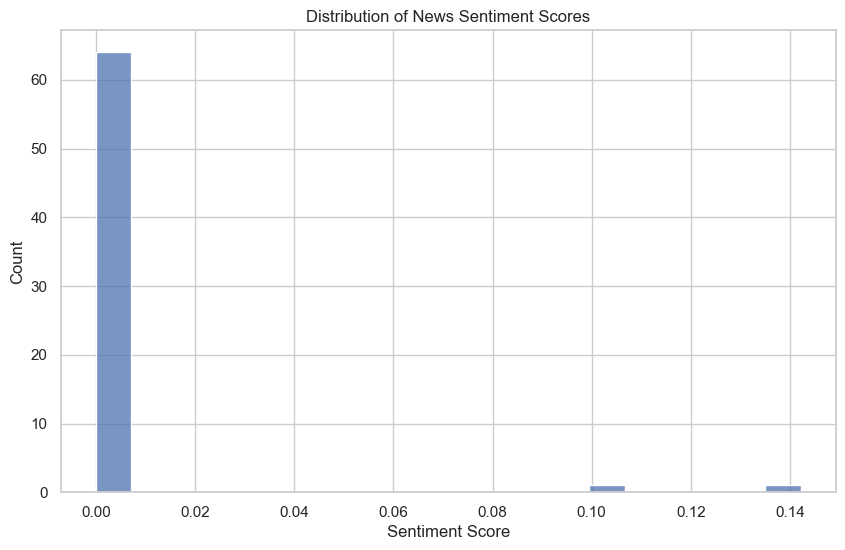

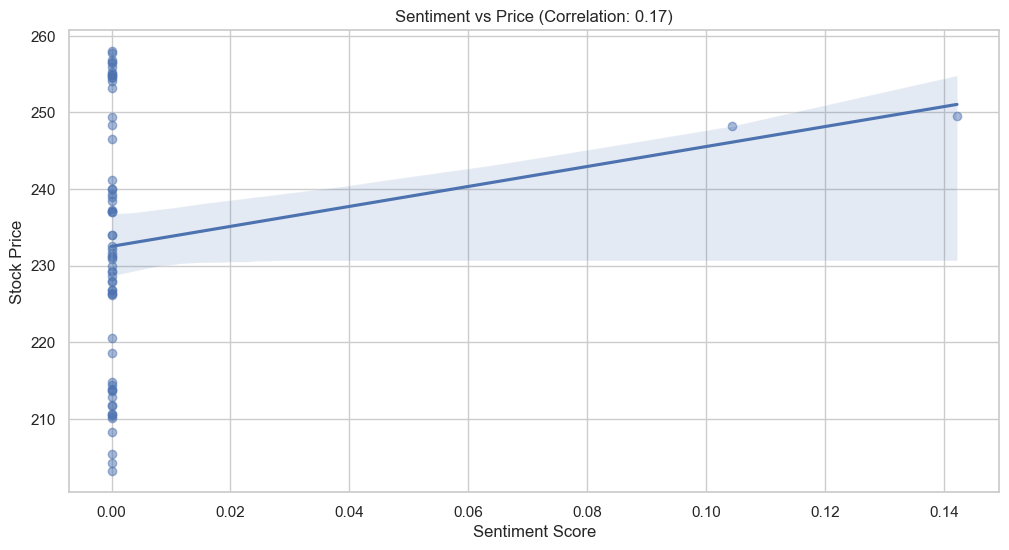

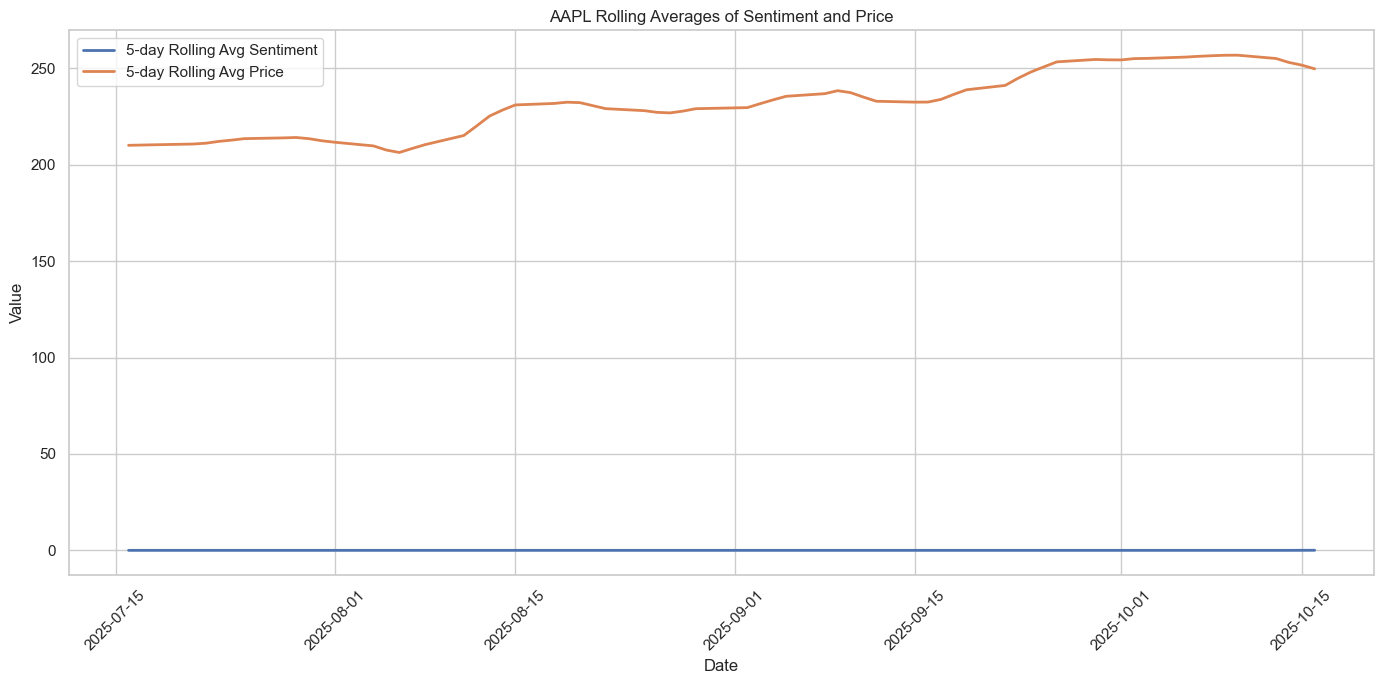

In [ ]:
# Check data
print("Number of rows in merged_df:", len(merged_df))
print("\nDate range:", merged_df.index.min(), "to", merged_df.index.max())
print("\nSample of data:")
print(merged_df[['sentiment_score', 'close']].head())

# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='sentiment_score', bins=20)
plt.title('Distribution of News Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.savefig(os.path.join(CONFIG['charts_path'], f'{CONFIG["ticker"]}_sentiment_dist.png'))
plt.show()

# 2. Correlation Analysis
plt.figure(figsize=(12, 6))
correlation = merged_df['sentiment_score'].corr(merged_df['close'])  # Remove rolling for now
sns.regplot(data=merged_df, x='sentiment_score', y='close', scatter_kws={'alpha':0.5})
plt.title(f'Sentiment vs Price (Correlation: {correlation:.2f})')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Price')
plt.savefig(os.path.join(CONFIG['charts_path'], f'{CONFIG["ticker"]}_sentiment_correlation.png'))
plt.show()

# 3. Rolling Statistics with additional checks
window = 5
plt.figure(figsize=(14, 7))

# Calculate rolling means with minimum_periods
sentiment_rolling = merged_df['sentiment_score'].rolling(window=window, min_periods=1).mean()
price_rolling = merged_df['close'].rolling(window=window, min_periods=1).mean()

# Plot with dates on x-axis
plt.plot(merged_df.index, sentiment_rolling, 
         label=f'{window}-day Rolling Avg Sentiment', linewidth=2)
plt.plot(merged_df.index, price_rolling, 
         label=f'{window}-day Rolling Avg Price', linewidth=2)

plt.title(f'{CONFIG["ticker"]} Rolling Averages of Sentiment and Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig(os.path.join(CONFIG['charts_path'], f'{CONFIG["ticker"]}_rolling_stats.png'))
plt.show()

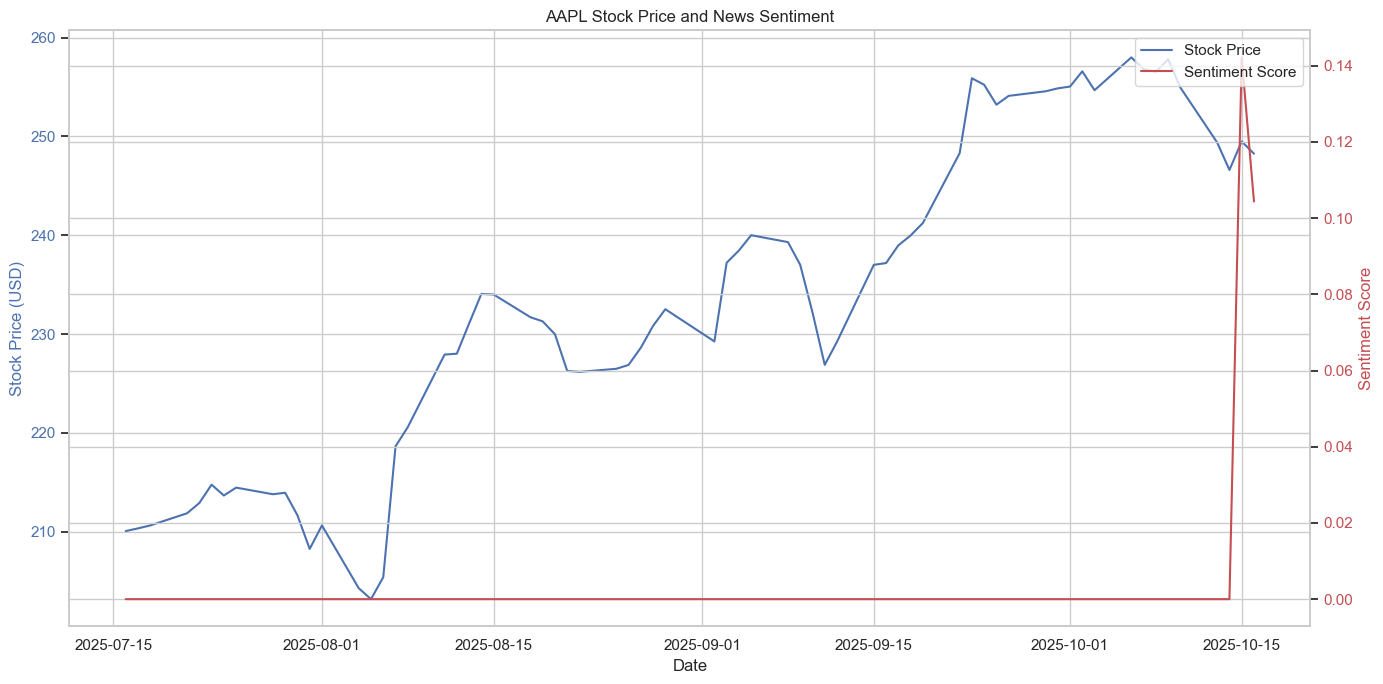

In [52]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock price
ax1.set_title(f'{CONFIG["ticker"]} Stock Price and News Sentiment')
ax1.plot(merged_df.index, merged_df['close'], color='b', label='Stock Price') # Use lowercase 'close'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price (USD)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['sentiment_score'], color='r', label='Sentiment Score')
ax2.set_ylabel('Sentiment Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()

## 6. Build a Simple Predictive Model

Here, we will build a basic logistic regression model to predict stock price movements based on sentiment and price data. Note the following:

1. **Features**: We'll use sentiment scores along with standard price/volume metrics.
2. **Target**: We're predicting whether the price will go up (1) or down (0) the next day.
3. **Limitations**: 
   - This is a simplified model for demonstration purposes
   - Real trading requires much more sophisticated analysis
   - Past performance doesn't guarantee future results
   - Always consult financial professionals for investment advice

Starting model preparation...
Initial data shape: (66, 8)

Creating features...

Feature Statistics:
       daily_return  high_low_ratio  close_to_open  volume_price_ratio  \
count     65.000000       66.000000      66.000000        6.600000e+01   
mean       0.002683        0.018654       0.000008        1.255074e+10   
std        0.015058        0.010040       0.013090        5.304432e+09   
min       -0.030161        0.007681      -0.037148        6.928659e+09   
25%       -0.005116        0.012943      -0.005491        9.615280e+09   
50%        0.001371        0.016598       0.000661        1.091142e+10   
75%        0.007670        0.020557       0.005390        1.377552e+10   
max        0.064436        0.059690       0.041951        3.949931e+10   

       volume_volatility  sentiment_score_raw  sentiment_ma2  
count          65.000000            66.000000      66.000000  
mean            0.066826             0.003735       0.002944  
std             0.473822             0.0215

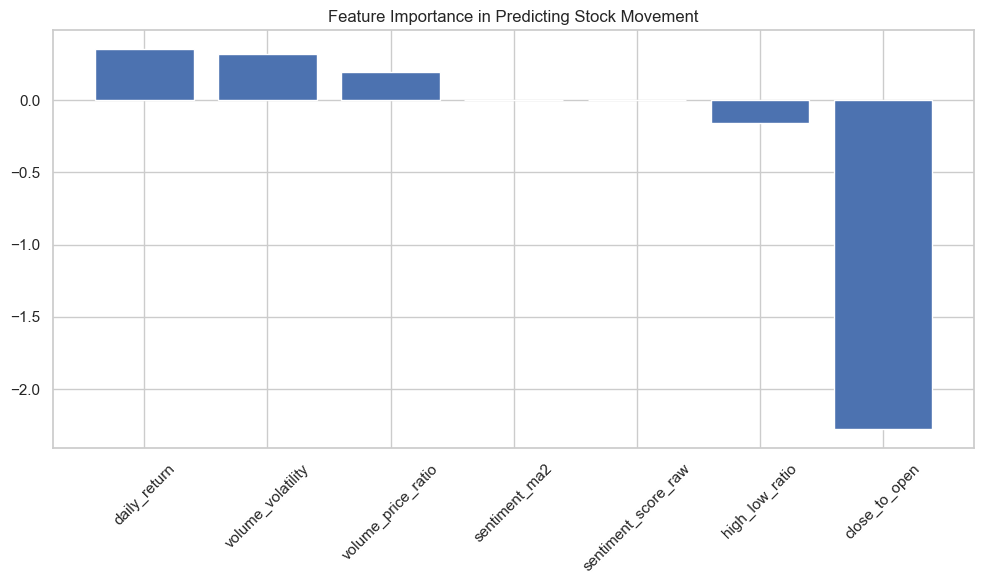

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def create_features(df):
    features_df = df.copy()
    
    # Price-based features that don't require much history
    features_df['daily_return'] = features_df['close'].pct_change(1)
    features_df['high_low_ratio'] = (features_df['high'] - features_df['low']) / features_df['open']
    features_df['close_to_open'] = (features_df['close'] - features_df['open']) / features_df['open']
    
    # Volume features
    features_df['volume_price_ratio'] = features_df['volume'] * features_df['close']
    features_df['volume_volatility'] = features_df['volume'].pct_change()
    
    # Sentiment features: use raw and smoothed
    features_df['sentiment_score_raw'] = features_df['sentiment_score']
    features_df['sentiment_ma2'] = features_df['sentiment_score'].rolling(window=2, min_periods=1).mean()
    
    return features_df

if not merged_df.empty:
    print("Starting model preparation...")
    print(f"Initial data shape: {merged_df.shape}")
    
    # Create features
    print("\nCreating features...")
    merged_df = create_features(merged_df)
    
    # Create target variable (next day's price movement)
    merged_df['price_change'] = merged_df['close'].diff()
    merged_df['target'] = (merged_df['price_change'].shift(-1) > 0).astype(int)
    
    # Define features
    features = [
        'daily_return',
        'high_low_ratio',
        'close_to_open',
        'volume_price_ratio',
        'volume_volatility',
        'sentiment_score_raw',
        'sentiment_ma2'
    ]
    
    print("\nFeature Statistics:")
    print(merged_df[features].describe())
    
    # Remove rows with NaN values
    print("\nHandling missing values...")
    print("NaN counts before cleaning:")
    print(merged_df[features + ['target']].isnull().sum())
    
    # Remove NaN values
    merged_df_clean = merged_df.dropna(subset=features + ['target'])
    
    print(f"\nRows after cleaning: {len(merged_df_clean)}")
    print("\nClass distribution:")
    if len(merged_df_clean) > 0:
        class_dist = merged_df_clean['target'].value_counts(normalize=True)
        print(class_dist)
        
        if len(merged_df_clean) < 50:  # Minimum sample requirement
            print(f"\nWarning: Limited data for reliable model training")
            print(f"Only {len(merged_df_clean)} samples available.")
            print("\nRecommendations:")
            print("1. Collect more historical data")
            print("2. Consider using minute-level data instead of daily")
            print("3. Try using a longer time period for data collection")
        else:
            # Proceed with model training only if we have enough data
            X = merged_df_clean[features]
            y = merged_df_clean['target']
            
            # Scale features
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
            
            # Determine splits based on data size
            n_splits = min(5, max(2, len(merged_df_clean) // 10))
            print(f"\nUsing {n_splits} splits for cross-validation")
            
            tscv = TimeSeriesSplit(n_splits=n_splits)
            
            # Results storage
            all_accuracies = []
            all_predictions = []
            feature_importance_list = []
            baseline_accuracies = []
            
            print("\nPerforming Time Series Cross-Validation:")
            for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled), 1):
                X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                print(f"\nFold {fold}:")
                print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
                
                # Calculate baseline accuracy
                majority_class = y_train.mode()[0]
                baseline_acc = (y_test == majority_class).mean()
                baseline_accuracies.append(baseline_acc)
                print(f"Baseline accuracy: {baseline_acc:.2f}")
                
                if len(np.unique(y_train)) > 1 and len(X_train) >= 30:
                    model = LogisticRegression(
                        max_iter=1000,
                        class_weight='balanced',
                        random_state=CONFIG['random_seed']
                    )
                    model.fit(X_train, y_train)
                    
                    predictions = model.predict(X_test)
                    all_predictions.extend(predictions)
                    accuracy = accuracy_score(y_test, predictions)
                    all_accuracies.append(accuracy)
                    
                    feature_importance_list.append(pd.Series(model.coef_[0], index=features))
                    
                    print(f"Model accuracy: {accuracy:.2f}")
                    print("\nConfusion Matrix:")
                    print(confusion_matrix(y_test, predictions))
                    print("\nClassification Report:")
                    print(classification_report(y_test, predictions))
                else:
                    print("Skipping fold: insufficient samples or class representation")
            
            if feature_importance_list:
                avg_feature_importance = pd.concat(feature_importance_list, axis=1).mean(axis=1)
                feature_importance_df = pd.DataFrame({
                    'Feature': features,
                    'Average Coefficient': avg_feature_importance
                })
                feature_importance_df = feature_importance_df.sort_values('Average Coefficient', ascending=False)
                
                print("\nOverall Results:")
                print(f"Average Model Accuracy: {np.mean(all_accuracies):.2f}")
                print(f"Average Baseline Accuracy: {np.mean(baseline_accuracies):.2f}")
                print(f"Accuracy Improvement: {np.mean(all_accuracies) - np.mean(baseline_accuracies):.2f}")
                print("\nFeature Importance:")
                print(feature_importance_df)
                
                # Visualization
                plt.figure(figsize=(10, 6))
                plt.bar(feature_importance_df['Feature'], feature_importance_df['Average Coefficient'])
                plt.xticks(rotation=45)
                plt.title('Feature Importance in Predicting Stock Movement')
                plt.tight_layout()
                plt.show()
            else:
                print("\nNo valid folds completed. Insufficient data for modeling.")
    else:
        print("\nError: No data after preprocessing.")
else:
    print("Error: No input data available.")